Mục tiêu của chúng ta là dự báo doanh số bán hàng trong tương lai tại các cửa hàng bán lẻ. Tập dữ liệu được lấy trên một cuộc thi của Kaggle từ một công ty ở Ecuador tên là Corporación Favorita, một nhà bán lẻ thực phẩm lớn. Công ty này cũng hoạt động ở các quốc gia khác ở Nam Mỹ.


<img src="https://raw.githubusercontent.com/EkremBayar/Kaggle/refs/heads/main/Images/CF.png" width="25%" />
<img src="https://raw.githubusercontent.com/EkremBayar/Kaggle/refs/heads/main/Images/CF1.jpg" width="35%" />




Có **54 cửa hàng** và **33 nhóm sản phẩm** trong dữ liệu. Chuỗi thời gian bắt đầu từ **2013-01-01** và kết thúc vào **2017-08-31**. Tuy nhiên, Kaggle đã cung cấp dữ liệu được chia thành hai phần là train và test. Ngày trong dữ liệu test là **15 ngày** sau ngày cuối cùng trong dữ liệu train.



**Nhiệm vụ chính của chúng ta đối với tập dữ liệu này là dự đoán doanh số cho từng nhóm sản phẩm và từng cửa hàng.**



Có 6 bộ dữ liệu mà chúng ta sẽ lần lượt phân tích:



1. _Train_

2. _Test_

3. _Store_

4. _Transactions_

5. _Holidays and Events_

6. _Daily Oil Price_



**Train data** chứa chuỗi thời gian của các tổ hợp cửa hàng và nhóm sản phẩm. Cột sales cung cấp tổng doanh số bán hàng của một nhóm sản phẩm tại một cửa hàng vào một ngày cụ thể. Giá trị phân số có thể xuất hiện do các sản phẩm có thể được bán theo đơn vị lẻ (chẳng hạn, 1,5 kg phô mai thay vì 1 túi khoai tây chiên). Cột onpromotion cho biết tổng số sản phẩm trong một nhóm đang được khuyến mãi tại một cửa hàng vào một ngày cụ thể.



**Store data** cung cấp thông tin về các cửa hàng như thành phố, bang, loại cửa hàng, và cụm.



**Transaction data** có mối tương quan cao với cột sales trong Train data. Dữ liệu này giúp hiểu được các mẫu bán hàng của các cửa hàng.



**Holidays and Events data** là siêu dữ liệu. Nó rất có giá trị để hiểu về doanh số trong quá khứ, xu hướng và các thành phần theo mùa.



**Daily Oil Price data** là một dữ liệu bổ sung hữu ích. Ecuador là một quốc gia phụ thuộc vào dầu mỏ và tình hình kinh tế của họ dễ bị ảnh hưởng bởi biến động giá dầu. Vì vậy, dữ liệu này giúp chúng ta hiểu nhóm sản phẩm nào bị ảnh hưởng tích cực hoặc tiêu cực bởi giá dầu.



Khi nhìn vào phần mô tả dữ liệu, bạn sẽ thấy “Ghi chú bổ sung”. Những ghi chú này có thể rất quan trọng để nhận ra các mẫu hoặc điểm bất thường. Dưới đây là một vài ghi chú quan trọng:



- Lương trong khu vực công được trả hai tuần một lần, vào ngày 15 và vào ngày cuối cùng của tháng. Doanh số bán hàng tại siêu thị có thể bị ảnh hưởng bởi điều này.

- Một trận động đất mạnh 7,8 độ đã xảy ra ở Ecuador vào ngày 16 tháng 4 năm 2016. Người dân đã tham gia vào các hoạt động cứu trợ, quyên góp nước và các nhu yếu phẩm khác, làm tăng đáng kể doanh số bán hàng tại siêu thị trong vài tuần sau đó.

# Khai báo thư viện

In [1]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 12.0 MB/s eta 0:00:00


In [2]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.4 MB/s eta 0:00:00


In [3]:
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

from IPython.display import display, Markdown, HTML

from scipy.stats import chi2, chi2_contingency

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.preprocessing import RobustScaler, LabelEncoder

from sklearn.preprocessing import PolynomialFeatures

from statsmodels.tsa.deterministic import DeterministicProcess,CalendarFourier

from scipy.signal import periodogram

import statsmodels.api as sm

from xgboost import XGBRegressor

# Đọc dữ liệu

In [4]:
import gdown

url = 'https://drive.google.com/uc?id=1jf2PFQl0p8Um9G_IbE1Bnk3xezyJG8kA'
output = 'train_data.csv'
gdown.download(url, output, quiet=False)

df_train = pd.read_csv(output)
df_test = pd.read_csv('https://drive.google.com/uc?id=1k_f609mLy5a8XD63zhNCf1g3uQW0LCcJ')
df_store = pd.read_csv('https://drive.google.com/uc?id=1sXVWpg7k5U-7R_8VbVbMgoohI9XKTasU')
df_transaction = pd.read_csv('https://drive.google.com/uc?id=1rd1j7ziuka_I3M4q2Q_8HBsQJGmjbdBC')
df_holiday = pd.read_csv('https://drive.google.com/uc?id=1XVD2RGiKLqT1J48SaMK2HIHUNX3ZXTjq')
df_oil = pd.read_csv('https://drive.google.com/uc?id=19fSYyNrhXrhljPwrWR10kcCt6Iir8XoG')

Downloading...
From (original): https://drive.google.com/uc?id=1jf2PFQl0p8Um9G_IbE1Bnk3xezyJG8kA
From (redirected): https://drive.google.com/uc?id=1jf2PFQl0p8Um9G_IbE1Bnk3xezyJG8kA&confirm=t&uuid=e301c398-beba-4a2b-9780-2dc10f932969
To: /content/train_data.csv
100%|██████████| 122M/122M [00:01<00:00, 94.6MB/s]


Train Data

In [5]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
display(Markdown(f"Số bản ghi của tập train : {df_train.shape[0]}"))

Số bản ghi của tập train : 3000888

Test Data

In [7]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [8]:
display(Markdown(f"Số bản ghi của tập test : {df_test.shape[0]}"))

Số bản ghi của tập test : 28512

Store Data

In [9]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [10]:
display(Markdown(f"Số bản ghi của tập store : {df_store.shape[0]}"))

Số bản ghi của tập store : 54

Transaction Data

In [11]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [12]:
display(Markdown(f"Số bản ghi của tập transaction : {df_transaction.shape[0]}"))

Số bản ghi của tập transaction : 83488

Holiday and Events Data

In [13]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [14]:
display(Markdown(f"Số bản ghi của tập holiday : {df_holiday.shape[0]}"))

Số bản ghi của tập holiday : 350

Daily Oil Price Data

In [15]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [16]:
display(Markdown(f"Số bản ghi của tập oil : {df_oil.shape[0]}"))

Số bản ghi của tập oil : 1218

Tập store, transaction, holiday và oil là các tập dữ liệu bổ sung cho tập train

## Tập dữ liệu Train

Cột `sales` là cột giá trị mà chúng ta cần dự đoán

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


Cột `id`, `store_nbr`, `onpromotion` mang kiểu dữ liệu int64, cột `date`, `family` mang kiểu object và `sales` mang kiểu float64

Tập train không có giá trị nào bị thiếu

In [18]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


In [19]:
duplicate_rows = df_train[df_train.duplicated()]

display(Markdown(f"Số dòng trùng lặp: {duplicate_rows.shape[0]}"))

Số dòng trùng lặp: 0

### Cột `id`

Biểu thị id riêng lẻ liên tục của từng bản ghi

In [20]:
df_train['id']

,id
0,0
1,1
2,2
3,3
4,4
...,...
3000883,3000883
3000884,3000884
3000885,3000885
3000886,3000886


In [21]:
# Chuyển kiểu dữ liệu sang định dạng nhỏ hơn

df_train['id'] = df_train['id'].astype('uint32')

### Cột `date`

In [22]:
df_train['date']

,date
0,2013-01-01
1,2013-01-01
2,2013-01-01
3,2013-01-01
4,2013-01-01
...,...
3000883,2017-08-15
3000884,2017-08-15
3000885,2017-08-15
3000886,2017-08-15


In [23]:
display(Markdown(f"Số ngày trong tập train là : {df_train['date'].nunique()}"))

Số ngày trong tập train là : 1684

In [24]:
#Chuyển kiểu dữ liệu của date từ object sang datetime

df_train['date'] = pd.to_datetime(df_train['date'])

In [25]:
full_date_range = pd.date_range(start=df_train['date'].min(), end=df_train['date'].max(), freq='D')

missing_dates = full_date_range.difference(df_train['date'])

missing_dates_str = [date.strftime('%Y-%m-%d') for date in missing_dates]



display(Markdown(f"Những ngày bị thiếu: {', '.join(missing_dates_str)}"))




Những ngày bị thiếu: 2013-12-25, 2014-12-25, 2015-12-25, 2016-12-25

Thời gian trong tập dữ liệu bị thiếu ngày 25/12 hàng năm

Tạo thêm các cột thờ gian từ cột `date`

In [26]:
df_train['date'] =  df_train['date'].dt.to_period('D')

In [27]:
df_train['year']  = df_train['date'].dt.year

df_train['month']  = df_train['date'].dt.month

df_train['day']  = df_train['date'].dt.day

df_train['dayofweek']  = df_train['date'].dt.day_of_week

df_train['dayofyear']  = df_train['date'].dt.day_of_year

### Cột `store_nbr`

In [28]:
display(Markdown(f"Danh sách các store : {', '.join(map(str, df_train['store_nbr'].sort_values().unique()))}"))




Danh sách các store : 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54

Cột `store_nbr` biểu thị các cửa hàng khác nhau nên sẽ đổi kiểu dữ liệu sang biến phân loại category

In [29]:
df_train['store_nbr'] = df_train['store_nbr'].astype('category')

### Cột `family`

In [30]:
print(f"Danh sách các nhóm mặt hàng {df_train['family'].unique()}")


Danh sách các nhóm mặt hàng ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


Cột `family` biểu thị từng nhóm mặt hàng trong từng cửa hàng. Chúng ta sẽ chuyển từ kiểu object sang category để tiện phân tích

In [31]:
df_train['family'] = df_train['family'].astype('category')

### Cột `sales`

Phân phối của cột `sales`

In [32]:
pd.options.display.float_format = '{:.2f}'.format

df_train['sales'].describe()

,sales
count,3000888.00
mean,357.78
std,1102.00
min,0.00
25%,0.00
50%,11.00
75%,195.85
max,124717.00


Sale nhận giá trị từ 0 đến 124 711. Trong đó giá trị bằng 0 chiếm phần lớn trong tập dữ liệu

In [33]:
display(Markdown(f"Số bản ghi có giá trị là 0 chiếm {(df_train[df_train['sales']==0].shape[0]* 100 / len(df_train)):.2f} % trong toàn bộ tập dữ liệu"))

Số bản ghi có giá trị là 0 chiếm 31.30 % trong toàn bộ tập dữ liệu

In [34]:
# Đổi kiểu dữ liệu sang định dạng nhỏ hơn

df_train['sales'] = df_train['sales'].astype('float32')

Kiểm tra xem những ngày có giá trị `sales` bằng 0

In [35]:
df_grouped = df_train.groupby(['date', 'store_nbr'])['sales'].sum()



df_sales_zero = df_grouped[df_grouped == 0].reset_index().groupby('store_nbr')['date'].apply(list)

df_sales_zero_count = df_sales_zero.apply(len).sort_values(ascending=False)

display(Markdown('**Số ngày mà cửa hàng có doanh thu là 0 lớn hơn 10 ngày**'))

df_sales_zero_count

<ipython-input-35-ed3c42eeb150>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_train.groupby(['date', 'store_nbr'])['sales'].sum()
<ipython-input-35-ed3c42eeb150>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sales_zero = df_grouped[df_grouped == 0].reset_index().groupby('store_nbr')['date'].apply(list)


**Số ngày mà cửa hàng có doanh thu là 0 lớn hơn 10 ngày**

,date
store_nbr,
52,1566
22,1011
42,962
21,934
29,808
20,773
53,515
36,131
18,115


- Có thể một ngày một số mặt hàng không bán được sản phẩm nào, nhưng cả một ngày cửa hàng không bán được sản phẩm nào và lặp lại nhiều lần là không hợp lí.

- Và rất nhiều store có số ngày không bán được mặt hàng nào là 5. Cùng kiểm tra tiếp

In [36]:
display(Markdown('Những ngày đều có điểm chung là 5 đều là 5 ngày này'))

df_sales_zero[3]

Những ngày đều có điểm chung là 5 đều là 5 ngày này

[Period('2013-01-01', 'D'),
 Period('2014-01-01', 'D'),
 Period('2015-01-01', 'D'),
 Period('2016-01-01', 'D'),
 Period('2017-01-01', 'D')]

Có vẻ các ngày đầu năm đều như vậy và có tính chất lặp lại. Ta sẽ kiểm tra những ngày khác đầu năm

In [37]:
def remove_new_year_days(dates):

    return [date for date in dates if date.strftime("%m-%d") != "01-01"]



df_sales_zero = df_sales_zero.apply(remove_new_year_days)

In [38]:
df_sales_zero = df_sales_zero[df_sales_zero.apply(lambda dates: len(dates) > 0)]

In [39]:
def calculate_date_range(dates):

    if len(dates) < 2:

        return 0

    return dates[-1].asfreq('D') - dates[0].asfreq('D')


In [40]:
index_list = df_sales_zero.index.unique()

for store in index_list:

  zero_range = calculate_date_range(df_sales_zero.loc[store])

  display(Markdown(f"""Miền giá trị store **{store}**: {df_sales_zero.loc[store][0]},{df_sales_zero.loc[store][-1]}, Số ngày lí thuyết **{zero_range}**, Số ngày thực tế **{len(df_sales_zero.loc[store])-1}**"""))




Miền giá trị store **1**: 2015-07-07,2015-07-07, Số ngày lí thuyết **0**, Số ngày thực tế **0**

Miền giá trị store **12**: 2015-03-30,2015-05-28, Số ngày lí thuyết **<59 * Days>**, Số ngày thực tế **59**

Miền giá trị store **14**: 2014-08-04,2014-09-10, Số ngày lí thuyết **<37 * Days>**, Số ngày thực tế **37**

Miền giá trị store **17**: 2016-03-22,2016-03-23, Số ngày lí thuyết **<Day>**, Số ngày thực tế **1**

Miền giá trị store **18**: 2016-08-15,2016-12-02, Số ngày lí thuyết **<109 * Days>**, Số ngày thực tế **109**

Miền giá trị store **20**: 2013-01-02,2015-02-12, Số ngày lí thuyết **<771 * Days>**, Số ngày thực tế **767**

Miền giá trị store **21**: 2013-01-02,2015-07-23, Số ngày lí thuyết **<932 * Days>**, Số ngày thực tế **928**

Miền giá trị store **22**: 2013-01-02,2015-10-08, Số ngày lí thuyết **<1009 * Days>**, Số ngày thực tế **1005**

Miền giá trị store **24**: 2014-04-14,2014-07-23, Số ngày lí thuyết **<100 * Days>**, Số ngày thực tế **100**

Miền giá trị store **25**: 2016-08-22,2016-10-26, Số ngày lí thuyết **<65 * Days>**, Số ngày thực tế **65**

Miền giá trị store **29**: 2013-01-02,2015-03-19, Số ngày lí thuyết **<806 * Days>**, Số ngày thực tế **802**

Miền giá trị store **30**: 2013-07-08,2013-07-30, Số ngày lí thuyết **<22 * Days>**, Số ngày thực tế **22**

Miền giá trị store **36**: 2013-01-02,2013-05-08, Số ngày lí thuyết **<126 * Days>**, Số ngày thực tế **126**

Miền giá trị store **42**: 2013-01-02,2015-08-20, Số ngày lí thuyết **<960 * Days>**, Số ngày thực tế **956**

Miền giá trị store **43**: 2016-11-14,2016-11-17, Số ngày lí thuyết **<3 * Days>**, Số ngày thực tế **3**

Miền giá trị store **52**: 2013-01-02,2017-04-19, Số ngày lí thuyết **<1568 * Days>**, Số ngày thực tế **1560**

Miền giá trị store **53**: 2013-01-02,2014-05-28, Số ngày lí thuyết **<511 * Days>**, Số ngày thực tế **509**

Nhận thấy số ngày thực tế và lý thuyết rất gần nhau. Tức là trong khoảng thời gian này các cửa hàng trên không bán được mặt hàng nào, và chỉ có một số ít rất nhỏ những ngày bán được ( ví dụ **806** và **802**, tức là chỉ có 4 ngày bán được hàng trên tổng số 806 ngày).



Theo dự đoán, có thể những ngày này các cửa hàng đóng cửa nên doanh thu là 0, chúng ta sẽ loại khỏi dữ liệu để tránh mô hình bị nhầm lẫn sau này.

In [41]:
def remove_empty(df):

    df = df[~((df.store_nbr == 52) & (df.date < "2017-04-20"))]

    df = df[~((df.store_nbr == 22) & (df.date < "2015-10-09"))]

    df = df[~((df.store_nbr == 42) & (df.date < "2015-08-21"))]

    df = df[~((df.store_nbr == 21) & (df.date < "2015-07-24"))]

    df = df[~((df.store_nbr == 29) & (df.date < "2015-03-20"))]

    df = df[~((df.store_nbr == 20) & (df.date < "2015-02-13"))]

    df = df[~((df.store_nbr == 53) & (df.date < "2014-05-29"))]

    df = df[~((df.store_nbr == 36) & (df.date < "2013-05-09"))]

    return df

In [42]:
df_train.shape

(3000888, 11)

In [43]:


df_train = remove_empty(df_train)

In [44]:
df_train.shape

(2780316, 11)

In [45]:
df_grouped = df_train.groupby(['store_nbr', 'family'])['sales'].sum()

display(Markdown('Danh sách các mặt hàng có doanh thu là 0 từ trước đến nay'))

df_grouped[df_grouped == 0]

<ipython-input-45-aae4da277138>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_train.groupby(['store_nbr', 'family'])['sales'].sum()


Danh sách các mặt hàng có doanh thu là 0 từ trước đến nay

store_nbr  family         
1          BABY CARE         0.00
9          BOOKS             0.00
10         BOOKS             0.00
11         BOOKS             0.00
12         BOOKS             0.00
13         BABY CARE         0.00
           BOOKS             0.00
14         BOOKS             0.00
           LAWN AND GARDEN   0.00
15         BOOKS             0.00
16         BOOKS             0.00
           LADIESWEAR        0.00
17         BOOKS             0.00
18         BOOKS             0.00
19         BOOKS             0.00
20         BOOKS             0.00
21         BOOKS             0.00
22         BOOKS             0.00
23         BABY CARE         0.00
25         LADIESWEAR        0.00
28         BOOKS             0.00
           LADIESWEAR        0.00
29         BOOKS             0.00
           LADIESWEAR        0.00
30         BOOKS             0.00
           LAWN AND GARDEN   0.00
31         BOOKS             0.00
32         BOOKS             0.00
           LADIESWEAR        0.00
33         BOOKS             0.00
           LADIESWEAR        0.00
34         BOOKS             0.00
35         BOOKS             0.00
           LADIESWEAR        0.00
36         BOOKS             0.00
39         BOOKS             0.00
40         BOOKS             0.00
           LADIESWEAR        0.00
43         BOOKS             0.00
           LADIESWEAR        0.00
44         BABY CARE         0.00
45         BABY CARE         0.00
46         BABY CARE         0.00
47         BABY CARE         0.00
48         BABY CARE         0.00
49         BABY CARE         0.00
50         BABY CARE         0.00
51         BABY CARE         0.00
52         BABY CARE         0.00
           BOOKS             0.00
54         BOOKS             0.00
           LADIESWEAR        0.00
           LAWN AND GARDEN   0.00
Name: sales, dtype: float32

Một số mặt hàng có doang thu là 0 suốt nhiều năm tại một số cửa hàng. Chúng ta có thể đoán rằng một số mặt hàng không được bán tại một số cửa hàng. Vì vậy khi dự đoán doanh thu, hiển nhiên chúng ta có thể dự đoán doanh thu cho những mặt hàng này là 0

### Cột onpromotion

Thống kê

In [46]:
df_train['onpromotion'].describe()

,onpromotion
count,2780316.00
mean,2.81
std,12.67
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,741.00


Cũng chiếm giá trị 0 là chủ yếu

In [47]:
display(Markdown(f"Số bản ghi có giá trị là 0 chiếm {(df_train[df_train['onpromotion']==0].shape[0]* 100 / len(df_train)):.2f} % trong toàn bộ tập dữ liệu"))

Số bản ghi có giá trị là 0 chiếm 78.01 % trong toàn bộ tập dữ liệu

In [48]:
# chuyển kiểu dữ liệu sang kiểu nhỏ hơn

df_train['onpromotion'] = df_train['onpromotion'].astype('uint32')

## Tập dữ liệu Test

Tương tự như tập train nhưng thiếu cột `sales`

In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


Xử lí tương tự

In [50]:
# chuyển kiểu dữ liệu

df_test['id'] = df_test['id'].astype('uint32')

df_test['date'] = pd.to_datetime(df_test['date'])

df_test['date'] = df_test['date'].dt.to_period('D')

df_test['store_nbr'] = df_test['store_nbr'].astype('category')

df_test['family'] = df_test['family'].astype('category')

df_test['onpromotion'] = df_test['onpromotion'].astype('uint32')

In [51]:
df_test['year']  = df_test['date'].dt.year

df_test['month']  = df_test['date'].dt.month

df_test['day']  = df_test['date'].dt.day

df_test['dayofweek']  = df_test['date'].dt.day_of_week

df_test['dayofyear']  = df_test['date'].dt.day_of_year

## Tập dữ liệu Store

In [52]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


Thông tin thêm về từng loại cửa hàng như city, state, type, cluster. Tập dữ liệu store không có giá trị bị thiếu

In [53]:
display(Markdown(

    '_Các thành phố :_  \n' +

    '\n'.join(sorted(df_store['city'].unique())) +



    '\n\n_Các tiểu bang :_ \n\n' +

    '\n'.join(sorted(df_store['state'].unique())) +



    '\n\n_Các kiểu cửa hàng :_  \n' +

    '\n'.join(sorted(df_store['type'].unique())) +



    '\n\n_Các nhóm cửa hàng :_  \n' +

    '\n'.join(map( str, sorted(df_store['cluster'].unique())))

))


_Các thành phố :_  
Ambato
Babahoyo
Cayambe
Cuenca
Daule
El Carmen
Esmeraldas
Guaranda
Guayaquil
Ibarra
Latacunga
Libertad
Loja
Machala
Manta
Playas
Puyo
Quevedo
Quito
Riobamba
Salinas
Santo Domingo

_Các tiểu bang :_ 

Azuay
Bolivar
Chimborazo
Cotopaxi
El Oro
Esmeraldas
Guayas
Imbabura
Loja
Los Rios
Manabi
Pastaza
Pichincha
Santa Elena
Santo Domingo de los Tsachilas
Tungurahua

_Các kiểu cửa hàng :_  
A
B
C
D
E

_Các nhóm cửa hàng :_  
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17

In [54]:
# đổi kiểu dữ liệu

df_store = df_store.apply(lambda x: x.astype('category'))


## Tập dữ liệu Transaction

In [55]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


Thông tin thêm về số giao dịch của mỗi cửa hàng trong một ngày. Không có giá trị bị thiếu

In [56]:
display(Markdown(f"Ngày nhỏ nhất: {df_transaction['date'].min()}  \nNgày lớn nhất: {df_transaction['date'].max()}"))

Ngày nhỏ nhất: 2013-01-01  
Ngày lớn nhất: 2017-08-15

Tập transaction không chứa số giao dịch trong tập test.

Thống kê

In [57]:
df_transaction['transactions'].describe()

,transactions
count,83488.00
mean,1694.60
std,963.29
min,5.00
25%,1046.00
50%,1393.00
75%,2079.00
max,8359.00


Miền giá trị đi từ 5 đến 8359

In [58]:
# chuyển đổi kiểu dữ liệu

df_transaction['date'] = pd.to_datetime(df_transaction['date'])

df_transaction['date'] = df_transaction['date'].dt.to_period('D')

df_transaction['store_nbr'] = df_transaction['store_nbr'].astype('category')

df_transaction['transactions'] = df_transaction['transactions'].astype('uint32')

## Tập dữ liệu Holiday

In [59]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


Tập dữ liệu là danh sách các ngày lễ. Có ảnh hưởng trưc tiếp tới những ngày doanh thu tăng đột biến

In [60]:
df_holiday.isnull().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


Tập holiday không có giá trị nào bị thiếu

In [61]:


display(Markdown(f"Ngày nhỏ nhất: {df_holiday['date'].min()}  \nNgày lớn nhất: {df_holiday['date'].max()}"))


Ngày nhỏ nhất: 2012-03-02  
Ngày lớn nhất: 2017-12-26

Tập dữ liệu của chúng ta đi từ '2013-01-01' đến '2017-08-31' cho nên những ngày không trong khoảng thời gian này sẽ loại bỏ

Tập holiday chứa cả ngày lễ trên tập test (2017-08-16 đến 2017-08-31)

In [62]:
df_holiday = df_holiday[(df_holiday['date'] >= '2013-01-01')& (df_holiday['date'] <= '2017-08-31')]


In [63]:
display(Markdown(

    '**Các loại ngày lễ:**  \n ' +

    ', '.join(sorted(df_holiday['type'].unique())) +



    '\n\n**Phạm vi khu vực:** \n\n ' +

    ', '.join(sorted(df_holiday['locale'].unique())) +



    '\n\n**Tên khu vực:**  \n ' +

    ', '.join(sorted(df_holiday['locale_name'].unique())) +



    '\n\n**Mô tả tên ngày lễ:**  \n' +

    ', '.join(sorted(df_holiday['description'].unique()))

))


**Các loại ngày lễ:**  
 Additional, Bridge, Event, Holiday, Transfer, Work Day

**Phạm vi khu vực:** 

 Local, National, Regional

**Tên khu vực:**  
 Ambato, Cayambe, Cotopaxi, Cuenca, Ecuador, El Carmen, Esmeraldas, Guaranda, Guayaquil, Ibarra, Imbabura, Latacunga, Libertad, Loja, Machala, Manta, Puyo, Quevedo, Quito, Riobamba, Salinas, Santa Elena, Santo Domingo, Santo Domingo de los Tsachilas

**Mô tả tên ngày lễ:**  
Batalla de Pichincha, Black Friday, Cantonizacion de Cayambe, Cantonizacion de El Carmen, Cantonizacion de Guaranda, Cantonizacion de Latacunga, Cantonizacion de Libertad, Cantonizacion de Quevedo, Cantonizacion de Riobamba, Cantonizacion de Salinas, Cantonizacion del Puyo, Carnaval, Cyber Monday, Dia de Difuntos, Dia de la Madre, Dia de la Madre-1, Dia del Trabajo, Fundacion de Ambato, Fundacion de Cuenca, Fundacion de Esmeraldas, Fundacion de Guayaquil, Fundacion de Guayaquil-1, Fundacion de Ibarra, Fundacion de Loja, Fundacion de Machala, Fundacion de Manta, Fundacion de Quito, Fundacion de Quito-1, Fundacion de Riobamba, Fundacion de Santo Domingo, Inauguracion Mundial de futbol Brasil, Independencia de Ambato, Independencia de Cuenca, Independencia de Guaranda, Independencia de Guayaquil, Independencia de Latacunga, Mundial de futbol Brasil: Cuartos de Final, Mundial de futbol Brasil: Ecuador-Francia, Mundial de futbol Brasil: Ecuador-Honduras, Mundial de futbol Brasil: Ecuador-Suiza, Mundial de futbol Brasil: Final, Mundial de futbol Brasil: Octavos de Final, Mundial de futbol Brasil: Semifinales, Mundial de futbol Brasil: Tercer y cuarto lugar, Navidad, Navidad+1, Navidad-1, Navidad-2, Navidad-3, Navidad-4, Primer Grito de Independencia, Primer dia del ano, Primer dia del ano-1, Provincializacion Santa Elena, Provincializacion de Cotopaxi, Provincializacion de Imbabura, Provincializacion de Santo Domingo, Puente Dia de Difuntos, Puente Navidad, Puente Primer dia del ano, Recupero Puente Dia de Difuntos, Recupero Puente Navidad, Recupero Puente Primer dia del ano, Recupero puente Navidad, Recupero puente primer dia del ano, Terremoto Manabi, Terremoto Manabi+1, Terremoto Manabi+10, Terremoto Manabi+11, Terremoto Manabi+12, Terremoto Manabi+13, Terremoto Manabi+14, Terremoto Manabi+15, Terremoto Manabi+16, Terremoto Manabi+17, Terremoto Manabi+18, Terremoto Manabi+19, Terremoto Manabi+2, Terremoto Manabi+20, Terremoto Manabi+21, Terremoto Manabi+22, Terremoto Manabi+23, Terremoto Manabi+24, Terremoto Manabi+25, Terremoto Manabi+26, Terremoto Manabi+27, Terremoto Manabi+28, Terremoto Manabi+29, Terremoto Manabi+3, Terremoto Manabi+30, Terremoto Manabi+4, Terremoto Manabi+5, Terremoto Manabi+6, Terremoto Manabi+7, Terremoto Manabi+8, Terremoto Manabi+9, Traslado Batalla de Pichincha, Traslado Fundacion de Guayaquil, Traslado Independencia de Guayaquil, Traslado Primer Grito de Independencia, Traslado Primer dia del ano, Viernes Santo

Các loại ngày lễ :

- Holiday : Ngày lễ

- Event : Sự kiện

- Transfer : Là một ngày lễ/ sự kiện đã được chuyển

- Bridge : Ngày bổ sung

- Additional : Ngày lễ/ sự kiện bổ sung

- Work Day : Ngày đi làm



❎ LƯU Ý:

- Cột `transferred` biểu thị ngày lễ/ sự kiện hôm đó có được chuyển hay không. Một ngày gọi là được chuyển khi theo lịch chính thức ngày lễ/ sự kiện đó rơi vào ngày dương lịch đó, nhưng đã được chính phủ chuyển sang một ngày khác. Ngày được chuyển như này giống một ngày bình thường hơn là một ngày lễ. Những ngày được chuyển sẽ có `type` là _Transfer_



  (ví dụ: Ngày lễ '_Independencia de Guayaquil_ ' đã được chuyển từ ngày 09/10/2012 sang ngày 12/10/2012, nghĩa là ngày này được tổ chức vào ngày 12/10/2012).

- Những ngày thuộc `type` là _Bridge_ là những ngày bổ sung được thêm vào một ngày lễ/ sự kiện (ví dụ: lịch nghỉ lễ là thứ 4 và thứ 5, thì sẽ có thêm ngày Bridge là thứ 6. Kết quả là sẽ nghĩ liên tục từ thứ 4 đến chủ nhật).

- Ngày có `type` là _Work Day_, là một ngày thường không được lên lịch làm việc (ví dụ: Thứ Bảy) nhưng vẫn phải đi làm. Ngày này nhằm mục đích bù lại ngày _Bridge_ .

- Các ngày lễ bổ sung (Addtional) là những ngày được thêm vào một ngày lễ lịch thông thường, ví dụ, thường xảy ra vào khoảng Giáng sinh (biến Đêm Giáng sinh thành một ngày lễ ).

Giá trị của cột `locale_name` tương ứng với từng giá trị trong `locale`:

- National : Quốc gia, `locale_name` tương ứng là Ecuador ( do tập dữ liệu chỉ giới hạn trong lãnh thổ Ecuador)

- Regional : Khu vực, `locale_name` tương ứng là các tiểu bang

- Local : Địa phương, `locale_name` tương ứng là các thành phố



↪ Như vậy, các ngày lễ chỉ có ảnh hưởng tới một số cửa hàng nhất định, do vị trí của các cửa hàng là khác nhau.

In [64]:
# chuyển đổi kiểu dữ liệu

df_holiday['date'] = pd.to_datetime(df_holiday['date'])

df_holiday['date'] = df_holiday['date'].dt.to_period('D')

df_holiday['type'] = df_holiday['type'].astype('category')

df_holiday['locale'] = df_holiday['locale'].astype('category')

df_holiday['locale_name'] = df_holiday['locale_name'].astype('category')

df_holiday['description'] = df_holiday['description'].astype('category')

<ipython-input-64-c8df4297115a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_holiday['date'] = pd.to_datetime(df_holiday['date'])
<ipython-input-64-c8df4297115a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_holiday['date'] = df_holiday['date'].dt.to_period('D')
<ipython-input-64-c8df4297115a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Xử lí dữ liệu trên cột `type`

#### Transfer

Kiểm tra những ngày lễ bị chuyển và những ngày lễ được chuyển

In [65]:


tr1 = df_holiday[ (df_holiday.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)

tr2 = df_holiday[(df_holiday.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)

In [66]:
display(HTML(f"""

<div style="display: flex; justify-content: space-around;">

    <div style="flex: 0.8; padding: 10px;">

        <h3>Các ngày bị chuyển</h3>

        {tr1.to_html(index=False)}

    </div>

    <div style="flex: 0.9; padding: 10px;">

        <h3>Các ngày được chuyển</h3>

        {tr2.to_html(index=False)}

    </div>

</div>

"""))

date,type,locale,locale_name,description
2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil
2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil
2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha
2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil
2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia
2017-01-01,Holiday,National,Ecuador,Primer dia del ano
2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha
2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia
date,type,locale,locale_name,description


Nhận thấy những ngày bị chuyển có `locale` và `locale_name` giống nhau. Nhưng `description` thì khác nhau. Chúng ta sẽ bỏ đi những ngày bị chuyển (do khi bị chuyển thì các ngày đó trở thành ngày thông thường, không ảnh hưởng đến doanh thu) và giữ lại các ngày được chuyển với description của ngày bị chuyển (do đó là tên gốc của ngày lễ để kết hợp giống nhau với các ngày lễ khác không chuyển).

Xử lí xong vấn đề Transfer cho nên chúng ta sẽ bỏ đi cột `transferred`

In [67]:
tr = pd.concat([tr1,tr2], axis = 1)

tr = tr.iloc[:, [5,1,2,3,4]]

In [68]:


display(Markdown('Các ngày sau khi chuyển'))

display(tr)

Các ngày sau khi chuyển

,date,type,locale,locale_name,description
0,2013-10-11,Holiday,National,Ecuador,Independencia de Guayaquil
1,2014-10-10,Holiday,National,Ecuador,Independencia de Guayaquil
2,2016-05-27,Holiday,National,Ecuador,Batalla de Pichincha
3,2016-07-24,Holiday,Local,Guayaquil,Fundacion de Guayaquil
4,2016-08-12,Holiday,National,Ecuador,Primer Grito de Independencia
5,2017-01-02,Holiday,National,Ecuador,Primer dia del ano
6,2017-04-13,Holiday,Local,Cuenca,Fundacion de Cuenca
7,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha
8,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia


Xóa đi cột `transferred` ở tập holliday và thêm các ngày có `type` là Transfer đã được xử lí vào tập holiday

In [69]:
df_holiday = df_holiday[(df_holiday.transferred == False) & (df_holiday.type != "Transfer")].drop("transferred", axis = 1)


In [70]:
df_holiday = pd.concat([df_holiday, tr], ignore_index=True)

In [71]:
display(Markdown('Tập dữ liệu holiday sau khi sử lí Transfer'))

df_holiday.head()

Tập dữ liệu holiday sau khi sử lí Transfer

,date,type,locale,locale_name,description
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano
3,2013-02-11,Holiday,National,Ecuador,Carnaval
4,2013-02-12,Holiday,National,Ecuador,Carnaval


#### Additional

Kiểm tra xem các ngày có `type` là Additional có gì đặc biệt không

In [72]:


df_holiday[df_holiday['type'] == 'Additional'].head(10)

,date,type,locale,locale_name,description
12,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1
23,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1
38,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1
41,2013-12-21,Additional,National,Ecuador,Navidad-4
42,2013-12-22,Additional,National,Ecuador,Navidad-3
44,2013-12-23,Additional,National,Ecuador,Navidad-2
45,2013-12-24,Additional,National,Ecuador,Navidad-1
47,2013-12-26,Additional,National,Ecuador,Navidad+1
48,2013-12-31,Additional,National,Ecuador,Primer dia del ano-1
59,2014-05-10,Additional,National,Ecuador,Dia de la Madre-1


- Các ngày Additional day có thêm hậu tố phía sau như -1, +1,... Ta sẽ xóa bỏ hậu tố để đồng nhất description với nhau.


In [73]:
df_holiday["description"] = df_holiday["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '',  regex=True)

Và đổi Addition thành Holiday do cùng là ngày lễ

In [74]:
df_holiday["type"] = np.where(df_holiday["type"] == "Additional", "Holiday", df_holiday["type"])

#### Bridge

Kiểm tra tương tự với các ngày có `type` là Bridge

In [75]:
df_holiday[df_holiday['type'] == 'Bridge']

,date,type,locale,locale_name,description
111,2014-12-26,Bridge,National,Ecuador,Puente Navidad
115,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano
226,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos


Nhận thấy phần `desription` đều có từ 'Puente' (có nghĩa tương đương Bridge). Kiểm tra một ngày cụ thể, ví dụ 2016-11-04 xem các ngày xung quanh như thế nào

In [76]:
df_holiday[(df_holiday['date'] > '2016-11-01') & (df_holiday['date'] < '2016-11-10')]

,date,type,locale,locale_name,description
224,2016-11-02,Holiday,National,Ecuador,Dia de Difuntos
225,2016-11-03,Holiday,National,Ecuador,Independencia de Cuenca
226,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos
227,2016-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo
228,2016-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena


Nhận thấy chỉ có ngày Bridge là có tiền tố Puente ở `description`, chúng ta sẽ xóa bỏ đi tiền tố này để đồng nhất các `description` và đổi `type` Bridge thành holiday do đều là ngày lễ.

In [77]:
df_holiday["description"] = df_holiday["description"].str.replace("Puente ", "")

df_holiday["type"] = np.where(df_holiday["type"] == "Bridge", "Holiday", df_holiday["type"])

#### Work Day

Những ngày Work Day là những ngày đi làm bù cho Bridge, cho nên không có ý nghĩa cho mặt doanh thu. Ta sẽ loại bỏ những ngày này khỏi tập holiday. Tuy nhiên, những ngày Work Day là những ngày cuối tuần, nơi mọi người có khả năng mua sắm cao hơn, lúc này khi tất cả mọi người đều đi làm thì khả năng doanh thu sẽ khác với cuối tuần những ngày thông thường. Chúng ta sẽ giữ lại những ngày này.

In [78]:
work_day = df_holiday[df_holiday.type == "Work Day"]

df_holiday = df_holiday[df_holiday.type != "Work Day"]

Kiểm tra tập work_day vừa tạo

In [79]:
work_day

,date,type,locale,locale_name,description
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano
104,2014-12-20,Work Day,National,Ecuador,Recupero Navidad
116,2015-01-10,Work Day,National,Ecuador,Recupero Primer dia del ano
232,2016-11-12,Work Day,National,Ecuador,Recupero Dia de Difuntos


Tập chỉ có 5 giá trị và đây là ngày đi làm bù cho nên `locale`, `locale_name`, `description` không quan trọng. Chúng ta sẽ chỉ lấy cột date

In [80]:
work_day = work_day[['date','type']].rename({"type":"IsWorkDay"}, axis = 1)

display(work_day)

,date,IsWorkDay
1,2013-01-05,Work Day
2,2013-01-12,Work Day
104,2014-12-20,Work Day
116,2015-01-10,Work Day
232,2016-11-12,Work Day


#### Event

In [81]:
display(Markdown(f"Các loại ngày lễ:  {', '.join(map(str, df_holiday['type'].unique()))}"))


Các loại ngày lễ:  Holiday, Event

Lúc này chỉ còn 2 loại ngày lễ là Event và Holiday. Kiểm tra xem Event có gì đặc biệt không

In [82]:
df_holiday[df_holiday['type']== 'Event'].head(10)

,date,type,locale,locale_name,description
14,2013-05-12,Event,National,Ecuador,Dia de la Madre
60,2014-05-11,Event,National,Ecuador,Dia de la Madre
63,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil
64,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorSuiza
65,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorHonduras
70,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorFrancia
71,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final
72,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final
73,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final
74,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final


In [83]:
df_holiday.loc[df_holiday['type']== 'Event', 'locale'].value_counts()

,count
locale,
National,56
Local,0
Regional,0


Tất cả `type` là Event đều có locale là National. Event và Holiday thực tế là hai loại khác nhau nên chúng ta sẽ chia riêng ra

In [84]:
events = df_holiday[df_holiday.type == "Event"]

events.head()

,date,type,locale,locale_name,description
14,2013-05-12,Event,National,Ecuador,Dia de la Madre
60,2014-05-11,Event,National,Ecuador,Dia de la Madre
63,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil
64,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorSuiza
65,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorHonduras


Do cột `locale` và `locale_name` giống nhau nên chúng ta sẽ xóa bỏ, và xóa bỏ `type` do tất cả đều là Event. Đồng thời thay đổi cột `description` thành `events` để phân biệt với holiday

In [85]:
events = events.drop(['locale', 'type', 'locale_name'], axis = 1).rename({"description":"events"}, axis = 1)

events.head()

,date,events
14,2013-05-12,Dia de la Madre
60,2014-05-11,Dia de la Madre
63,2014-06-12,Inauguracion Mundial de futbol Brasil
64,2014-06-15,Mundial de futbol Brasil: EcuadorSuiza
65,2014-06-20,Mundial de futbol Brasil: EcuadorHonduras


Cập nhật tập holiday

In [86]:
df_holiday = df_holiday[df_holiday['type'] != "Event"].drop("type", axis=1)


### Xử lí trên cột `locale`

Do tập events chỉ có một loại giá trị `locale` là National nên chúng ta giữ nguyên. Còn holiday chia ra thành 3 tập tương ứng với National, Regional, Local.

Chúng ta sẽ đổi tên cột Local và Reginal thành city và state để tương đồng với các cột của tập store

In [87]:
regional = df_holiday[df_holiday.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1)

national = df_holiday[df_holiday.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1)

local = df_holiday[df_holiday.locale == "Local"].rename({ "locale_name":"city", "description":"holiday_local"}, axis = 1).drop("locale", axis = 1)

In [88]:
regional = regional[~ regional.duplicated()]

national = national[~ national.duplicated()]

local = local[~ local.duplicated()]

events = events[~ events.duplicated()]

### Lúc này từ tập holiday ban đầu chúng ta đã phân tích thành các tập

- work_day

- events

- regional

- national

- local

## Tập dữ liệu Daily Oil Price

In [89]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [90]:
display(Markdown('Số giá trị bị thiếu là '))

display(df_oil.isnull().sum())

Số giá trị bị thiếu là 

,0
date,0
dcoilwtico,43


43 giá trị bị thiếu trên `dcoilwtico`

In [91]:
display(Markdown(f"Ngày nhỏ nhất: {df_oil['date'].min()}  \nNgày lớn nhất: {df_oil['date'].max()}"))

Ngày nhỏ nhất: 2013-01-01  
Ngày lớn nhất: 2017-08-31

Tập oil chứa giá trị cả trong tập test

In [92]:
display(Markdown('**Thống kê**'))

df_oil['dcoilwtico'].describe()

**Thống kê**

,dcoilwtico
count,1175.00
mean,67.71
std,25.63
min,26.19
25%,46.41
50%,53.19
75%,95.66
max,110.62


In [93]:
# chuyển kiểu dữ liệu

df_oil['date'] = pd.to_datetime(df_oil['date'])

df_oil['dcoilwtico'] = df_oil['dcoilwtico'].astype('float32')

In [94]:
fig = px.line(df_oil, x='date', y='dcoilwtico', title='Biểu đồ giá trị theo thời gian', markers=True)

fig.update_layout(xaxis_title='Thời gian', yaxis_title='Giá dầu')

fig.show()

Nhận thấy giá dầu có biến động theo chu kì và có thể nội suy được giá trị bị thiếu

In [95]:
#df_oil["dcoilwtico"] = np.where(df_oil["dcoilwtico"] == 0, np.nan, df_oil["dcoilwtico"])

df_oil["dcoilwtico_interpolated"] =df_oil.dcoilwtico.interpolate()

In [96]:
fig = px.line(df_oil.sort_values("date"),

              x='date',

              y='dcoilwtico',

              title="Giá dầu sau khi nội suy"

              )

fig.add_scatter(x=df_oil['date'],

                 y=df_oil['dcoilwtico_interpolated'],

                 mode='lines',

                 name='dcoilwtico_interpolated',

                 line=dict(color='orange'))



fig.show()


Nhận thấy khá khớp với dữ liệu

In [97]:
df_oil = df_oil.drop('dcoilwtico', axis =1)

Kiểm tra số giá trị bị thiếu được lấp đầy hoàn toàn chưa

In [98]:
df_oil['dcoilwtico_interpolated'].isnull().sum()

1

Còn một giá trị, kiểm tra

In [99]:
df_oil.loc[df_oil['dcoilwtico_interpolated'].isnull()]


,date,dcoilwtico_interpolated
0,2013-01-01,NaN


Đây là dòng đâu tiên nên có lẽ không thể nội suy, ta sẽ thay thế dựa trên giá trị liền sau nó

In [100]:
df_oil.head()

,date,dcoilwtico_interpolated
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [101]:
df_oil.loc[0, 'dcoilwtico_interpolated'] = df_oil.loc[1, 'dcoilwtico_interpolated']

df_oil.head()

,date,dcoilwtico_interpolated
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


## Hợp nhất các tập dữ liệu

In [102]:
df_merged = pd.merge(pd.concat([df_train, df_test], ignore_index=True), df_store)

In [103]:
df_oil['date'] = df_oil['date'].dt.to_period('D')

In [104]:
df_merged = pd.merge(df_merged, df_oil,  how='left', on='date')

In [105]:
df_merged = pd.merge(df_merged, df_transaction, how='left', on=['date', 'store_nbr'])

In [106]:
df_merged.shape

(2808828, 17)

In [107]:
df_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,dayofyear,city,state,type,cluster,dcoilwtico_interpolated,transactions
2808823,3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,243,Quito,Pichincha,B,6,47.26,NaN
2808824,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,243,Quito,Pichincha,B,6,47.26,NaN
2808825,3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,243,Quito,Pichincha,B,6,47.26,NaN
2808826,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,243,Quito,Pichincha,B,6,47.26,NaN
2808827,3029399,2017-08-31,9,SEAFOOD,NaN,0,2017,8,31,3,243,Quito,Pichincha,B,6,47.26,NaN


Các tập dữ liệu liên quan đến ngày lễ chúng ta sẽ hợp nhất sau

Các giá trị NaN  sau khi kết hợp chúng ta sẽ xử lí sau

# Trực quan hóa dữ liệu

In [108]:
df_merged.set_index('date', inplace=True)

In [109]:
fig = px.pie(

    df_merged.groupby('type')['sales'].mean().reset_index(),

    values='sales',

    names='type',

    title='Trung Bình Doanh Thu Theo Loại Cửa Hàng',

    hole=0.7

)

fig.update_traces(textinfo='label')

fig.show()

<ipython-input-109-75536e9771d3>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [110]:
fig = px.bar(

    df_merged.groupby('family')['sales'].mean().reset_index().sort_values(by='sales', ascending=True).tail(10),

    y='family',

    x='sales',

    title="Trung bình doanh thu 10 nhóm sản phẩm cao nhất")

fig.update_layout(xaxis_title='Nhóm sản phẩm', yaxis_title='Trung bình doanh thu')

fig.show()

<ipython-input-110-83fe1da1aa39>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [111]:
fig = px.bar(

    df_merged.groupby('cluster')['sales'].mean().reset_index().sort_values(by='cluster', ascending=True),

    x='cluster',

    y='sales',

    title="Trung bình doanh thu các nhóm cửa hàng")

fig.update_layout(xaxis_title='Nhóm cửa hàng', yaxis_title='Trung bình doanh thu')

fig.show()

<ipython-input-111-d75e72e6715a>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [112]:
fig = px.line(

    df_merged.groupby(['year', 'month'])['sales'].mean().reset_index(),

    x='month',

    y='sales',

    color='year',

    title='Doanh thu Trung bình Hàng tháng',

    markers=True)



fig.update_layout(xaxis_title='Tháng', yaxis_title='Doanh thu trung bình')

fig.show()

Nhìn chung có thể thấy xu hướng tăng doanh thu theo từng năm và cuối năm có khả năng cao hơn. Ta cùng kiểm tra

In [113]:
fig = px.line(

    df_merged.groupby('year')['sales'].mean().reset_index(),

    x= 'year',

    y='sales',

    title='Doanh thu Trung bình Hàng Năm',

    markers=True)



fig.update_layout(xaxis_title='Năm', yaxis_title='Doanh thu trung bình')

fig.show()

Có thể khẳng định rằng doanh thu có xu hướng tăng dần

In [114]:
daily_sales = df_merged.groupby(['dayofyear', 'year'])['sales'].mean().reset_index()



daily_sales.columns = ['dayofyear', 'year', 'average_sales']

fig = px.line(

    daily_sales,

    x='dayofyear',

    y='average_sales',

    color='year',

    title='Doanh thu Trung bình Hàng Ngày',

    labels={'average_sales': 'Doanh thu trung bình', 'dayofyear': 'Ngày trong năm'},

    markers=True

)



fig.update_layout(xaxis_title='Ngày trong năm', yaxis_title='Doanh thu trung bình')

fig.show()


Nhận thấy các ngày 1 trong năm có doanh thu rất thấp

Kiểm tra một thuộc tính khác là Transaction- số giao dịch

In [115]:
fig = px.line(

    df_merged.groupby(['year', 'month'])['transactions'].mean().reset_index(),

    x='month',

    y='transactions',

    color='year',

    title='Số Giao Dịch Trung bình Hàng tháng',

    markers=True)



fig.update_layout(xaxis_title='Tháng', yaxis_title='Số Giao Dịch trung bình')

fig.show()

Có thể thấy số giao dịch trung bình tại tháng 12 tăng mạnh so với các tháng còn lại

In [116]:
fig = px.line(

    df_merged.groupby(['year', 'day'])['transactions'].mean().reset_index(),

    x='day',

    y='transactions',

    color='year',

    title='Số Giao Dịch Trung bình Hàng Ngày',

    markers=True)



fig.update_layout(xaxis_title='Ngày', yaxis_title='Số Giao Dịch trung bình')

fig.show()

Cuối tháng có vẻ số giao dịch trung bình tăng

In [117]:
fig = px.line(

    df_merged.groupby(['month', 'day'])['sales'].mean().reset_index(),

    x='day',

    y='sales',

    color='month',

    title='Doanh Thu Trung bình Hàng Ngày',

    markers=True)



fig.update_layout(xaxis_title='Ngày', yaxis_title='Doanh Thu trung bình')

fig.show()

Doanh thu không có sự thay đổi rõ rệt với các ngày trong tháng. Chỉ có tháng 1 là có doanh thu ngày 1 thấp và doanh thu những ngày cuối tháng 12 cao hơn những tháng còn lại

Kiểm tra theo từng thứ trong tuần

In [118]:
df_merged['dayofweek'] = df_merged.index.to_timestamp().day_name()

In [119]:


day_order = {

    'Monday': 0,

    'Tuesday': 1,

    'Wednesday': 2,

    'Thursday': 3,

    'Friday': 4,

    'Saturday': 5,

    'Sunday': 6

}

df_merged['dayofweek_order'] = df_merged['dayofweek'].map(day_order)

In [120]:
fig = px.line(

    df_merged.groupby(['year', 'dayofweek', 'dayofweek_order'])['sales'].mean().reset_index().sort_values(by='dayofweek_order', ascending=True),

    x='dayofweek',

    y='sales',

    color='year',

    title='Doanh thu trung bình các ngày trong tuần',

    markers=True)



fig.update_layout(xaxis_title='Thứ', yaxis_title='Doanh Thu trung bình')

fig.show()

Có thể thấy doanh thu tăng vào cuối tuần và giảm nhẹ vào thứ năm.

Kiểm tra xem số giao dịch như nào

In [121]:
fig = px.line(

    df_merged.groupby(['year', 'dayofweek', 'dayofweek_order'])['transactions'].mean().reset_index().sort_values(by='dayofweek_order', ascending=True),

    x='dayofweek',

    y='transactions',

    color='year',

    title='Số giao dịch trung bình các ngày trong tuần',

    markers=True)



fig.update_layout(xaxis_title='Thứ', yaxis_title='Số giao dịch trung bình')

fig.show()

Có vẻ số giao dịch có khác biệt rõ rệt hơn là doanh thu. Khi số giao dịch tăng mạnh vào thứ 7

✅ Chúng ta rút ra được vài điều sau khi trực quan hóa:

- Có sự khác biệt về doanh thu giữa các nhóm sản phẩm và cửa hàng khác nhau

- Doanh thu qua từng năm có một xu hướng

- Số giao dịch tăng mạnh vào cuối năm, cụ thể tháng 12

- Số giao dịch tăng nhẹ vào cuối tháng nhưng doanh thu thì ngang nhau

- Số giao dịch tăng mạnh vào cuối tuần, cụ thể thứ 7

- Ngày đầu tiên trong năm có doanh thu rất thấp

# Phân tích tập dữ liệu

- Thông qua việc doanh thu tăng vào tháng 12 và tăng vào thứ 7, chúng ta đã có cột `month` và `dayofweek` biểu thị điểm đặc biệt cho mô hình

- Ngày đầu tiên trong năm có doanh thu rất thấp, chúng ta sẽ lưu ý cho mô hình

In [122]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2808828 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 17 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   id                       uint32  
 1   store_nbr                category
 2   family                   category
 3   sales                    float32 
 4   onpromotion              uint32  
 5   year                     int64   
 6   month                    int64   
 7   day                      int64   
 8   dayofweek                object  
 9   dayofyear                int64   
 10  city                     category
 11  state                    category
 12  type                     category
 13  cluster                  category
 14  dcoilwtico_interpolated  float32 
 15  transactions             float64 
 16  dayofweek_order          int64   
dtypes: category(6), float32(2), float64(1), int64(5), object(1), uint32(2)
memory usage: 230.4+ MB


Kiểm tra xem ngày đầu năm có phải ngày đặc biệt nào không

In [123]:
national[(national['date'].dt.month == 1) & (national['date'].dt.day == 1)]

,date,holiday_national
0,2013-01-01,Primer dia del ano
49,2014-01-01,Primer dia del ano
114,2015-01-01,Primer dia del ano
166,2016-01-01,Primer dia del ano


Những ngày này đều là _Primer dia del ano_, tức là đã được đánh dấu để mô hình lưu ý. Nhưng ngày đầu năm của năm 2017 thì chưa có nên chúng ta sẽ thêm vào tập dữ liệu

In [124]:
new_row = pd.DataFrame({'date': pd.to_datetime(['2017-01-01']).to_period('D'), 'holiday_national': ['Primer dia del ano']})

national = pd.concat([national, new_row], ignore_index=True)

In [125]:
national[(national['date'].dt.month == 1) & (national['date'].dt.day == 1)]

,date,holiday_national
0,2013-01-01,Primer dia del ano
17,2014-01-01,Primer dia del ano
34,2015-01-01,Primer dia del ano
53,2016-01-01,Primer dia del ano
82,2017-01-01,Primer dia del ano


## Xử lí giá trị bị thiếu

In [126]:
display(Markdown('Kiểm tra số giá trị bị thiếu mỗi cột'))

df_merged.isnull().sum()

Kiểm tra số giá trị bị thiếu mỗi cột

,0
id,0
store_nbr,0
family,0
sales,28512
onpromotion,0
year,0
month,0
day,0
dayofweek,0
dayofyear,0


Có 3 cột có giá trị bị thiếu:

- Cột `sales` : số giá trị bị thiếu chính là số giá trị chúng ta cần dự đoán

- Cột `dcoilwico_interpolated` và `transactions`: chúng ta sẽ xử lí các cột này

In [127]:
df_merged.rename(columns={'dcoilwtico_interpolated': 'dcoilwtico'}, inplace=True)


In [128]:
display(Markdown('Những ngày mà  dcoilwtico bị thiếu'))

display(df_merged[df_merged['dcoilwtico'].isna()].index.unique())

Những ngày mà  dcoilwtico bị thiếu

PeriodIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
             '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
             '2013-02-02', '2013-02-03',
             ...
             '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
             '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
             '2017-08-26', '2017-08-27'],
            dtype='period[D]', name='date', length=485)

Ta sẽ nội suy giống như đã làm ở trước

In [129]:
df_merged['dcoilwtico'] = df_merged.dcoilwtico.interpolate()

In [130]:
display(Markdown(f"Số giá trị bị thiếu của dcoilwtico sau khi xử lí : {df_merged['dcoilwtico'].isnull().sum()}"))

Số giá trị bị thiếu của dcoilwtico sau khi xử lí : 0

Tiếp tục với `transactions`

In [131]:
display(Markdown('Kiểm tra những ngày transaction bị thiếu có đặc điểm gì '))

display(df_merged[df_merged['transactions'].isna()].sample(5))

Kiểm tra những ngày transaction bị thiếu có đặc điểm gì 

,id,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,dayofyear,city,state,type,cluster,dcoilwtico,transactions,dayofweek_order
date,,,,,,,,,,,,,,,,,
2013-01-01,1549,51,SCHOOL AND OFFICE SUPPLIES,0.00,0,2013,1,1,Tuesday,1,Guayaquil,Guayas,A,17,93.14,NaN,1
2017-08-23,3014547,41,PRODUCE,NaN,186,2017,8,23,Wednesday,235,Machala,El Oro,D,4,48.45,NaN,2
2015-05-05,1518368,12,BREAD/BAKERY,0.00,0,2015,5,5,Tuesday,125,Latacunga,Cotopaxi,C,15,60.38,NaN,1
2017-01-01,2596512,13,CELEBRATION,0.00,0,2017,1,1,Sunday,1,Latacunga,Cotopaxi,C,15,53.37,NaN,6
2017-08-28,3022709,21,DAIRY,NaN,8,2017,8,28,Monday,240,Santo Domingo,Santo Domingo de los Tsachilas,B,6,46.40,NaN,0


Nhận thấy khả năng cao những ngày transaction bị thiếu thì doanh thu đều bằng 0. Kiểm tra chi tiết hơn

In [132]:
display(Markdown('Những ngày transaction bị thiếu và doanh thu khác 0 là : '))

display(df_merged.loc[(df_merged['transactions'].isna()) & (df_merged['sales'] != 0)& (  df_merged['sales'].isna()== False)].index.unique())

Những ngày transaction bị thiếu và doanh thu khác 0 là : 

PeriodIndex(['2013-06-19', '2014-01-02', '2014-03-24', '2016-01-01',
             '2016-01-02', '2016-01-03', '2016-01-04', '2016-09-27'],
            dtype='period[D]', name='date')

Có 8 ngày là số giao dịch bị thiếu và doanh thu khác 0. Vậy những ngày doanh thu bằng 0 thì số giao dịch sẽ phải là 0. Chúng ta sẽ thay thế giá trị bị thiếu bằng 0

In [133]:
df_merged.loc[(df_merged['transactions'].isna()) & (df_merged['sales'] == 0), 'transactions'] = 0

Giá trị `transactions` của 8 ngày bị thiếu hiện chúng ta sẽ xử lí sau

In [134]:
df_merged.reset_index(inplace = True)

In [135]:
# chuyển kiểu dữ liệu

df_merged['month'] = df_merged['month'].astype('category')

df_merged['year'] = df_merged['year'].astype('category')

df_merged['day'] = df_merged['day'].astype('category')

df_merged['dayofweek'] = df_merged['dayofweek'].astype('category')

df_merged = df_merged.drop('dayofweek_order', axis = 1)

## Phân tích mối tương quan giữa các biến

Chúng ta sẽ xem những biến nào có quan hệ phụ thuộc với biến dự đoán để giữ lại cho mô hình sau này

### Mối quan hệ giữa các biến liên tục với biến dự đoán `sales`

Chúng ta sẽ sử dụng chỉ số correlation, tức mức độ tương quan giữa hai biến:

- 1: Tương quan dương hoàn hảo (khi một biến tăng, biến kia cũng tăng tương ứng).

- 1: Tương quan âm hoàn hảo (khi một biến tăng, biến kia giảm).

- 0: Không có tương quan giữa hai biến.

Vậy những biến có chỉ số càng gần 0 chúng ta sẽ không lấy, và giữ lại những biến có độ tương quan vượt một ngưỡng nào đó, ở đây chúng ta chọn 0.3

In [136]:
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns.to_list()

display(Markdown(f"Danh sách các biến kiểu số: {', '.join(numeric_columns)}"))


Danh sách các biến kiểu số: id, sales, onpromotion, dayofyear, dcoilwtico, transactions

`id` sẽ là cột để chúng ta nộp bài test độ chính xác của mô hình nên sẽ không phân tích

In [137]:
if 'id' in numeric_columns:

    numeric_columns.remove('id')

In [138]:
df_merged[numeric_columns].corr()['sales']

,sales
sales,1.00
onpromotion,0.42
dayofyear,0.02
dcoilwtico,-0.06
transactions,0.22


- `onpromotion` có độ tương quan trung bình, chúng ta sẽ lấy. Đây là số sản phẩm giảm giá nên chủ cửa hàng có thể điều chỉnh được để ảnh hưởng đến doanh thu

- `dcoilwtico` có độ tương quan rất thấp so với doanh thu, có lẽ chỉ có một số ít sản phẩm bị ảnh hưởng bởi giá dầu. Vì vậy chúng ta sẽ không lấy cột này.

- `transactions` có độ tương quan tương đối thấp. Mặc dù cột này rất hữu ích trong quá trình phân tích nhưng có lẽ không phù hợp cho việc đưa vào mô hình. Và thuộc tính này cũng không có trong tập test cho nên chúng ta có thể nghĩ đến việc bỏ đi cột này

- `dayofyear` cũng có độ tương quan thấp. Có lẽ chỉ có ngày đầu tiên là khác biệt rõ rệt.

In [139]:
df_merged = df_merged.drop(['dcoilwtico', 'transactions', 'dayofyear'], axis = 1)

### Mối tương quan giữa các biến phân loại với biến dự đoán `sales`

In [140]:
category_columns = df_merged.select_dtypes('category').columns.to_list()

display(Markdown(f"Danh sách các biến phân loại: {', '.join(category_columns)}"))


Danh sách các biến phân loại: store_nbr, family, year, month, day, dayofweek, city, state, type, cluster

Chúng ta sẽ sử dụng kiểm định giả thuyết để xem các biến có phụ thuộc không

 Kiểm định giả thuyết với Tukey HSD



**Mục tiêu**: Xác định sự khác biệt có ý nghĩa về doanh thu giữa các biến phân loại.



Giả thuyết kiểm định

- **H0**: Không có sự khác biệt về doanh thu giữa các nhóm trong biến phân loại .

- **H1**: Có ít nhất một cặp nhóm có sự khác biệt về doanh thu .



**Phương pháp**: Sử dụng kiểm định Tukey HSD. Nếu p-value < 0.05, bác bỏ H0.



Kết quả

Kết quả kiểm định sẽ cho ra các trường hợp bác bỏ và không. Nếu trường hợp bác bỏ đủ nhiều, chúng ta sẽ giữ lại. Ngược lại, chúng ta sẽ không đưa vào mô hình.


In [141]:
df_tukey = df_merged[df_merged['date'] < '2017-08-16']

In [142]:
for col in category_columns:

    tukey_result = pairwise_tukeyhsd(df_tukey['sales'], df_tukey[col], alpha=0.05)

    tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

    reject_counts = tukey_df['reject'].value_counts()

    display(Markdown(f"Số trường hợp của biến **{col}** : True: {reject_counts.get(True, 0)}, False: {reject_counts.get(False, 0)}"))

Số trường hợp của biến **store_nbr** : True: 1291, False: 140

Số trường hợp của biến **family** : True: 417, False: 111

Số trường hợp của biến **year** : True: 10, False: 0

Số trường hợp của biến **month** : True: 52, False: 14

Số trường hợp của biến **day** : True: 233, False: 232

Số trường hợp của biến **dayofweek** : True: 20, False: 1

Số trường hợp của biến **city** : True: 198, False: 33

Số trường hợp của biến **state** : True: 102, False: 18

Số trường hợp của biến **type** : True: 9, False: 1

Số trường hợp của biến **cluster** : True: 130, False: 6

Chỉ có biến `day` là có trường hợp bác bỏ thấp (231 < 234) cho nên chúng ta sẽ giữ lại các biến kia và bỏ đi biến `day`

In [143]:
del df_tukey

In [144]:
df_merged = df_merged.drop('day', axis = 1)

Thêm tập dữ liệu ngày lễ vào

In [145]:
df_merged.shape

(2808828, 13)

In [146]:
# Work Day

df_merged = df_merged.merge(work_day, how='left', on='date')

# National

df_merged = pd.merge(df_merged, national, how = "left", on="date")

# Regional

df_merged = pd.merge(df_merged, regional, how = "left", on = ["date", "state"])

# Local

df_merged = pd.merge(df_merged, local, how = "left", on = ["date", "city"])

# Event

df_merged = pd.merge(df_merged, events, how = "left", on = ["date"])

In [147]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810577 entries, 0 to 2810576
Data columns (total 18 columns):
 #   Column            Dtype    
---  ------            -----    
 0   date              period[D]
 1   id                uint32   
 2   store_nbr         category 
 3   family            category 
 4   sales             float32  
 5   onpromotion       uint32   
 6   year              category 
 7   month             category 
 8   dayofweek         category 
 9   city              object   
 10  state             object   
 11  type              category 
 12  cluster           category 
 13  IsWorkDay         object   
 14  holiday_national  object   
 15  holiday_regional  object   
 16  holiday_local     object   
 17  events            object   
dtypes: category(7), float32(1), object(7), period[D](1), uint32(2)
memory usage: 222.5+ MB


In [148]:
# chuyển kiểu dữ liệu

object_columns = df_merged.select_dtypes(include=['object']).columns

df_merged[object_columns] = df_merged[object_columns].astype('category')


In [149]:
df_merged.head()

,date,id,store_nbr,family,sales,onpromotion,year,month,dayofweek,city,state,type,cluster,IsWorkDay,holiday_national,holiday_regional,holiday_local,events
0,2013-01-01,0,1,AUTOMOTIVE,0.00,0,2013,1,Tuesday,Quito,Pichincha,D,13,NaN,Primer dia del ano,NaN,NaN,NaN
1,2013-01-01,1,1,BABY CARE,0.00,0,2013,1,Tuesday,Quito,Pichincha,D,13,NaN,Primer dia del ano,NaN,NaN,NaN
2,2013-01-01,2,1,BEAUTY,0.00,0,2013,1,Tuesday,Quito,Pichincha,D,13,NaN,Primer dia del ano,NaN,NaN,NaN
3,2013-01-01,3,1,BEVERAGES,0.00,0,2013,1,Tuesday,Quito,Pichincha,D,13,NaN,Primer dia del ano,NaN,NaN,NaN
4,2013-01-01,4,1,BOOKS,0.00,0,2013,1,Tuesday,Quito,Pichincha,D,13,NaN,Primer dia del ano,NaN,NaN,NaN


Chúng ta sẽ xử lí các cột ngày lễ mới thêm

In [150]:
# Work Day

df_merged = df_merged.rename(columns={'IsWorkDay': 'work_day'})

df_merged['work_day'] = np.where(df_merged['work_day'].isna(), 0, 1)

Sau đó chúng ta sẽ chuyển từng ngày lễ thành từng cột theo phương pháp dummies

In [151]:
def one_hot_encode(df, columns, nan_dummie = True, dropfirst = False):

    original_columns = list(df.columns)

    dummie_columns = columns

    df = pd.get_dummies(df, columns=dummie_columns, dummy_na=nan_dummie, drop_first=dropfirst)

    df.columns = df.columns.str.replace(" ", "_")

    new_columns = [c for c in df.columns if c not in original_columns]

    return df, new_columns


In [152]:
column_to_dummie = ['holiday_national',	'holiday_regional',	'holiday_local',	'events']

In [153]:
df_merged , dumme_columns = one_hot_encode(df=df_merged, columns=column_to_dummie, nan_dummie=False, dropfirst=False)

In [154]:
del events, work_day, local, national, regional

In [155]:
display(Markdown(f"Số cột mới được tạo thành từ 4 cột cũ là {len(dumme_columns)}"))

Số cột mới được tạo thành từ 4 cột cũ là 51

Kiểm tra xem có cột nào không phụ thuộc với biến dự đoán không

In [156]:
df_tukey = df_merged[df_merged['date']< '2017-08-16']

columns_with_false_one = []

for col in dumme_columns:

    tukey_result = pairwise_tukeyhsd(df_tukey['sales'], df_tukey[col], alpha=0.05)

    tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

    reject_counts = tukey_df['reject'].value_counts()

    if reject_counts.get(False, 0) == 1:

        columns_with_false_one.append(col)


In [157]:
display(Markdown(f"**Các biến không phụ thuộc là** ({len(columns_with_false_one)}) : {', '.join(columns_with_false_one)}"))

**Các biến không phụ thuộc là** (21) : holiday_national_Primer_Grito_de_Independencia, holiday_regional_Provincializacion_de_Santo_Domingo, holiday_local_Cantonizacion_de_Cayambe, holiday_local_Cantonizacion_de_El_Carmen, holiday_local_Cantonizacion_de_Libertad, holiday_local_Cantonizacion_de_Quevedo, holiday_local_Cantonizacion_de_Salinas, holiday_local_Cantonizacion_del_Puyo, holiday_local_Fundacion_de_Ambato, holiday_local_Fundacion_de_Cuenca, holiday_local_Fundacion_de_Esmeraldas, holiday_local_Fundacion_de_Ibarra, holiday_local_Fundacion_de_Loja, holiday_local_Fundacion_de_Machala, holiday_local_Fundacion_de_Manta, holiday_local_Fundacion_de_Santo_Domingo, holiday_local_Independencia_de_Ambato, holiday_local_Independencia_de_Guaranda, events_Black_Friday, events_Dia_de_la_Madre, events_Mundial_de_futbol_Brasil:_Semifinales

Chúng ta sẽ xóa những cột này

In [158]:
df_merged = df_merged.drop(columns_with_false_one, axis = 1)

In [159]:
display(Markdown(f"Số dòng: **{df_merged.shape[0]}**, Số cột: **{df_merged.shape[1]}**"))

Số dòng: **2810577**, Số cột: **44**

In [160]:
display(Markdown('Xem lại các kiểu dữ liệu của thuộc tính'))

df_merged.info()

Xem lại các kiểu dữ liệu của thuộc tính

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810577 entries, 0 to 2810576
Data columns (total 44 columns):
 #   Column                                                  Dtype    
---  ------                                                  -----    
 0   date                                                    period[D]
 1   id                                                      uint32   
 2   store_nbr                                               category 
 3   family                                                  category 
 4   sales                                                   float32  
 5   onpromotion                                             uint32   
 6   year                                                    category 
 7   month                                                   category 
 8   dayofweek                                               category 
 9   city                                                    category 
 10  state                         

In [161]:
df_merged['work_day'] = df_merged['work_day'].astype('bool')

del df_tukey

# Chuẩn hóa dữ liệu

In [162]:
df_transform = df_merged.copy()

In [163]:
df_store_and_family = df_transform[['store_nbr','family']]

In [164]:
type_order = {

    'A': 0,

    'B': 1,

    'C': 2,

    'D': 3,

    'E': 4

}

df_transform['type'] = df_transform['type'].map(type_order)
df_transform['type'] = df_transform['type'].astype('int')

In [165]:
column_to_dummie_transform = ['store_nbr', 'family', 'city', 'state', 'cluster', 'month', 'year', 'dayofweek']


In [166]:
df_transform , _ = one_hot_encode(df=df_transform, columns= column_to_dummie_transform, nan_dummie=False, dropfirst=False)

In [167]:
df_transform = pd.concat([df_transform, df_store_and_family], axis=1)


In [168]:
df_transform.shape

(2810577, 204)

In [169]:
df_transform.head()

,date,id,sales,onpromotion,type,work_day,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,...,year_2017,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,store_nbr,family
0,2013-01-01,0,0.00,0,3,False,False,False,False,False,...,False,False,False,False,False,False,True,False,1,AUTOMOTIVE
1,2013-01-01,1,0.00,0,3,False,False,False,False,False,...,False,False,False,False,False,False,True,False,1,BABY CARE
2,2013-01-01,2,0.00,0,3,False,False,False,False,False,...,False,False,False,False,False,False,True,False,1,BEAUTY
3,2013-01-01,3,0.00,0,3,False,False,False,False,False,...,False,False,False,False,False,False,True,False,1,BEVERAGES
4,2013-01-01,4,0.00,0,3,False,False,False,False,False,...,False,False,False,False,False,False,True,False,1,BOOKS


# Xây dựng mô hình

Thuật toán chính chúng ta sử dụng trong bài toán này là XGBoost

Mục tiêu của chúng ta là dự đoán doanh thu cho 15 ngày kế tiếp sao cho sai số chênh lệnh là nhỏ nhất. Ở đây chúng ta sẽ sử dụng sai số RMSLE ( tính sai số dựa trên giá trị chênh lệch lấy log cơ số mũ tự nhiên). Do giá trị doanh thu chênh lệch rất lớn và đều dương nên hàm đánh giá này rất phù hợp.

In [170]:
def rmsle(y_true, y_pred):

    # Hàm tính rmsle

    log_true = np.log1p(y_true)

    log_pred = np.log1p(y_pred)

    rmsle_value = np.sqrt(np.mean((log_true - log_pred) ** 2))

    return rmsle_value


In [171]:
df_zeros = df_train.groupby(["store_nbr", "family"]).sales.sum().reset_index()
df_zeros = df_zeros[df_zeros.sales==0]

<ipython-input-171-7db972fb13f8>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Những sản phẩm không bán tại một số cửa hàng sẽ mặc định dự đoán là 0

In [172]:
def zero_unused_families(df_zeros, df_preds, df_unfamily_lag):
    # Merge df_preds và df_unfamily_lag dựa trên cột 'id'
    temp_df = pd.merge(df_preds, df_unfamily_lag, on='id', how='left')

    # Merge temp_df với df_zeros để kiểm tra điều kiện
    merged_df = pd.merge(temp_df, df_zeros[['store_nbr', 'family']], on=['store_nbr', 'family'], how='left', indicator=True)

    # Thay sales bằng 0 cho những dòng có mặt trong df_zeros (thông qua cột '_merge')
    merged_df.loc[merged_df['_merge'] == 'both', 'sales'] = 0

    # Loại bỏ cột '_merge' sau khi xử lý
    merged_df.drop(columns=['_merge'], inplace=True)

    # Trả về kết quả với cột 'id' và 'sales'
    return merged_df[['id', 'sales']]

## Mô hình kinh điển trong bài toán hồi quy - Linear Regression

Đầu tiên chúng ta thử kiểm tra trên thuật toán cơ bản xem kết quả ra sao

Chia tập dữ liệu

In [173]:
train = df_transform[df_transform['date'] < '2017-08-16']
test = df_transform[df_transform['date'] >= '2017-08-16']

In [174]:
X_train = train.drop(['date', 'id', 'sales','store_nbr','family'], axis =1)
y_train = train['sales']
df_unfamily = test[['id', 'date', 'store_nbr','family']]
X_test = test.drop(['date',  'sales','store_nbr','family'], axis =1)

Huấn luyện mô hình

In [175]:
lr = LinearRegression(fit_intercept= False)
lr.fit(X_train,np.log1p(y_train))

LinearRegression(fit_intercept=False)

In [176]:
def make_predictions(model, X_test):
    pred_df = pd.DataFrame()
    id_df = pd.DataFrame()
    id_df['id'] = X_test['id'].copy()
    id_df.reset_index(drop=True, inplace=True)
    xgb_test = X_test.drop('id', axis = 1)
    xgb_pred = pd.Series(model.predict(xgb_test))
    xgb_pred[ xgb_pred < 0]= 0
    xgb_pred = np.expm1(xgb_pred)
    pred_df['sales'] = xgb_pred
    pred_df['id'] = id_df['id']
    return pred_df

In [178]:
y_pred = make_predictions(lr, X_test)

In [179]:
df_pred = zero_unused_families(df_zeros, y_pred, df_unfamily)

In [180]:
df_pred.to_csv('LinerRegression.csv', index=False)

Nhận thấy mục tiêu của chúng ta là tối ưu kết quả trên hàm rmsle. Nhưng thuật toán của chúng ta sử dụng trên hàm rmse. Chúng ta sẽ áp dụng **log** trên biến dự đoán.

Kết quả chạy trên tập test không áp dụng log cho kết quả rmsle là **1.93793** ( khá cao)

Kết quả chạy thử khi đổi biến dự đoán doanh thu với tham số log : **0.89540** ( Kết quả tốt hơn rất nhiều)

## Mô hình XGBoost

XGBoost (Extreme Gradient Boosting) là một thuật toán học máy mạnh mẽ và hiệu quả, sử dụng kỹ thuật gradient boosting để cải thiện dự đoán. Nó xây dựng một loạt các cây quyết định (decision trees) để tối ưu hóa sai sót và tạo ra mô hình mạnh mẽ hơn qua từng bước.

Khi áp dụng log trên biến dự đoán cho kết quả tốt hơn. Cho nên từ giờ về sau chúng ta sẽ sử dụng log trên biến dự đoán

In [181]:
xgb = XGBRegressor(eval_metric='rmse')
xgb.fit(X_train, np.log1p(y_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [182]:
y_pred_xgb = make_predictions(xgb, X_test)

In [183]:
df_pred_xgb = zero_unused_families(df_zeros, y_pred_xgb, df_unfamily)
df_pred_xgb.to_csv('XGBoost.csv', index=False)

Điểm rmsle là 0.52407 ( tốt hơn so với linear regression)

XGBoost có  hiệu suất cao hơn nên chúng ta sẽ chọn làm thuật toán chính

# Kết hợp thêm phân tích time-series

Time series = trend + seasson + cycle + error

Ở đây :
- Trend là xu hướng của dữ liệu
- Seasson là tính theo mùa của dữ liệu
- Cycle là chu kì của dữ liệu
- Error là các lỗi mà mô hình của chúng ta chưa thể dự đoán được

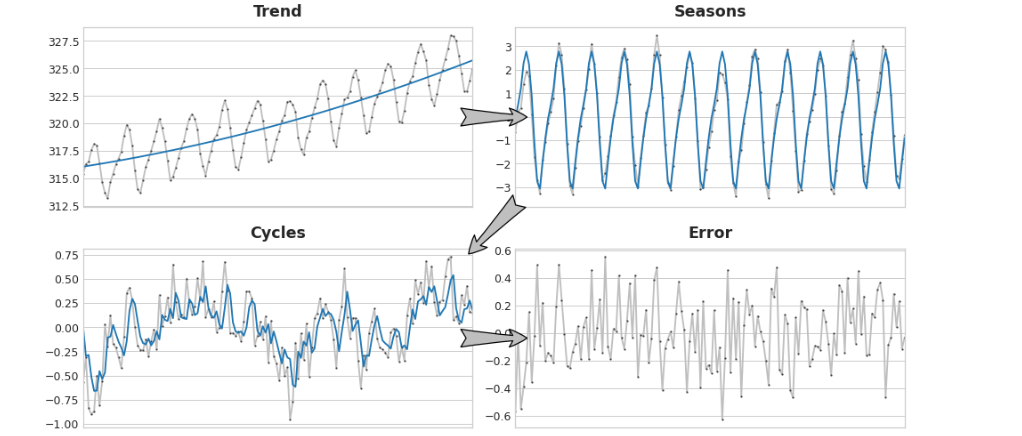

Như hình trên, khi chúng ta xác định được các tính năng này sẽ giúp mô hình vừa khít với dữ liệu hơn

## Trend

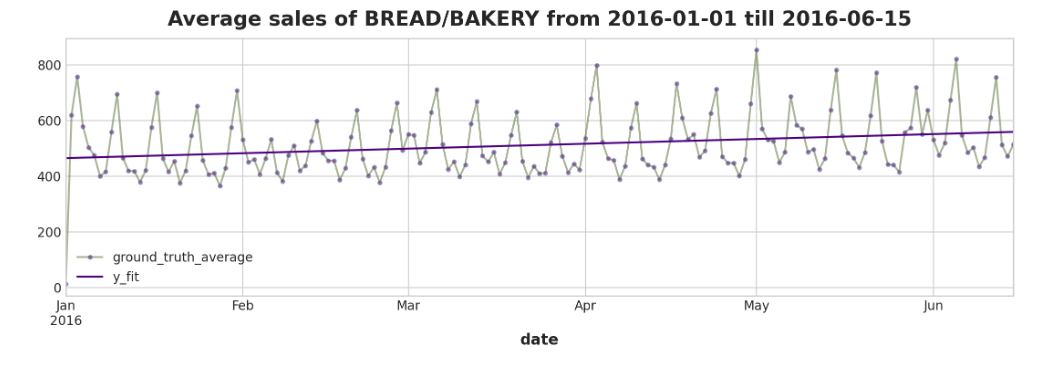

Xu hướng chính là một đường thẳng tuyến tính giúp mô hình học được xu hướng từ dữ liệu. Xu hướng bậc càng cao càng khớp với dữ liệu huấn luyện. Tuy nhiên nếu bậc cao quá sẽ dẫn đến một vài trường hợp xấu:

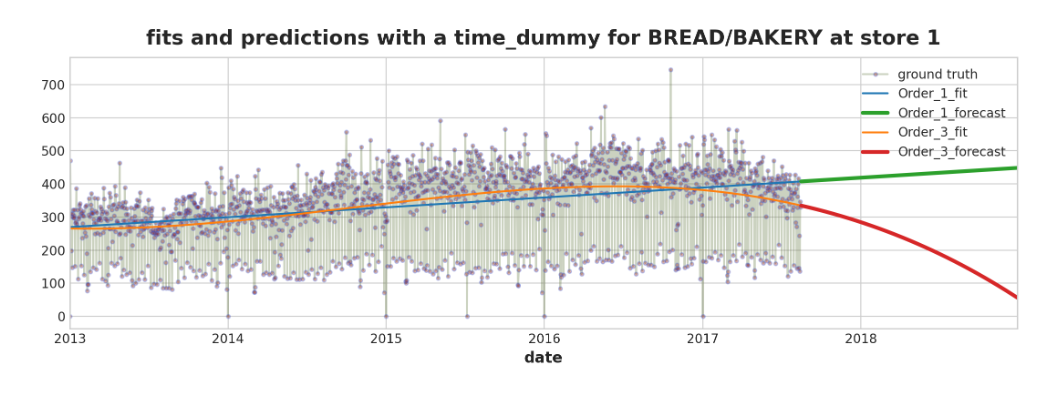

Hình trên cho thấy nếu bậc 3 thì mô hình sẽ khớp với dữ liệu nhưng cho kết quả dự đoán rất tệ. Bậc 1 cho kết quả thiên hướng cân bằng hơn

In [184]:

# Chúng ta sẽ sử dụng xu hướng bậc 1
dp = DeterministicProcess(

    index= df_transform['date'].unique(),

    constant=False,

    order=1

)

X_time = dp.in_sample()

In [185]:
X_time = X_time.reset_index()
X_time.rename(columns ={'index':'date'},inplace=True)
df_transform = df_transform.merge(X_time, how= 'left',on='date')

## Seasson

Tính theo mùa là sự lặp lại của dữ liệu có tính chu kì theo một khoảng thời gian xác định

Chúng ta sử dụng biểu đồ periodgram để xác định tần số của các khoảng thời gian nào là lớn

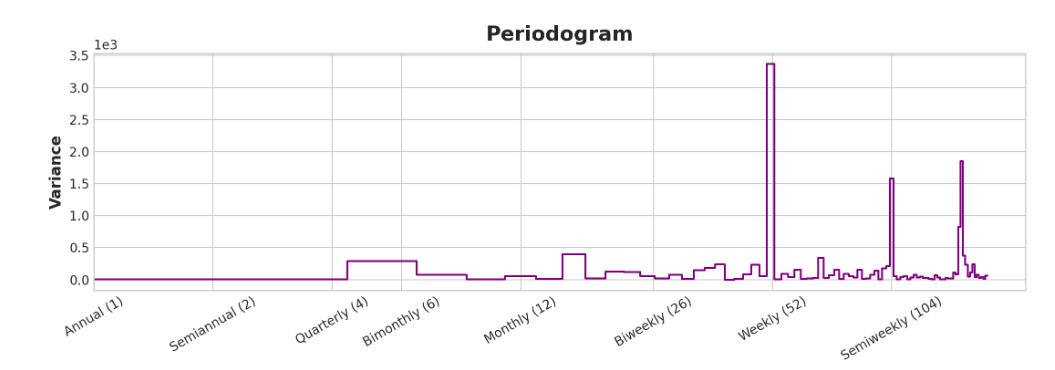

Trong tập dữ liệu của chúng ta, tần số của weekly là lớn nhất tính theo doanh thu trung bình. Chúng ta sẽ tạo tính năng dựa trên weekly. Tuy nhiên trước đó chúng ta đã tạo cột `dayofweek` biểu thị rồi nên sẽ bỏ qua bước này

## Cycle

Chu kì cũng có sự lặp lại như tính theo mùa. Tuy nhiên ít phụ thuộc vào mốc thời gian nhất định ( như hàng tuần, hàng tháng,...) mà thường bị ảnh hưởng bởi một mốc thời gian có thể thay đổi. Nói chung chu kì cũng giống với tính theo mùa nhưng ít bị phụ thuộc bởi mốc thời gian hơn.

Để xác định những thay đổi mang tính chu kì. Chúng ta sẽ tạo ra các biến gọi là `lag` feature. Đây là dữ liệu trong quá khứ, ví dụ để biết doanh thu có tính chất lặp lại hay không nhưng không phải theo tuần, theo tháng, theo năm mà là một khoảng thời gian có thể thay đổi, chúng ta sẽ tạo ra các lag_1, lag_2, ... là các doanh thu của 1 ngày trước, 2 ngày trước,....Ngoài ra, chúng ta có thể tạo thêm tính năng trung bình động, tức là doanh thu trung bình của các ngày trước. Số lượng thời gian là do chúng ta quy định, thông thường chúng ta sẽ tính doanh thu trung bình của những ngày gần đây, giả sử như 20 ngày, 30 ngày, 60 ngày. Nếu quá xa có thể không ảnh hưởng đến doanh thu hiện tại

Do số ngày dự đoán là 16 nên không thể tạo tính năng `lag` với nhỏ hơn hoặc bằng 16

Thực hiện tạo các tính năng cycle

In [186]:
def create_lags(df):



    new_df = df.copy()

    keys = ['store_nbr', 'family']

    val = 'sales'

    lags = [ 1, 7, 16, 21, 30, 45, 60, 90, 120, 365, 730]



    for lag in lags:

        new_df['lag_' + str(lag)] = new_df.groupby(keys)[val].transform(lambda x: x.shift(lag))



    return new_df





In [187]:
def create_rolling_mean(df):



    new_df = df.sort_values(["store_nbr", "family", "date"]).copy()

    shifts = [20, 30, 45, 60, 90, 120, 365, 730]



    for i in [20]:

        new_df["SMA"+str(i)+"_sales_lag16"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values

        new_df["SMA"+str(i)+"_sales_lag30"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values

        new_df["SMA"+str(i)+"_sales_lag60"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values
        new_df["SMA"+str(i)+"_sales_lag1"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(1).values





    return new_df

In [188]:
# df_transform  = df_transform.drop(['SMA20_sales_lag16', 'SMA20_sales_lag30', 'SMA20_sales_lag30'], axis = 1)

In [189]:
df_transform = create_lags(df_transform)
df_transform = create_rolling_mean(df_transform)

<ipython-input-186-28d7fa292e20>:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-186-28d7fa292e20>:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-186-28d7fa292e20>:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-186-28d7fa292e20>:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

## Error

Error (lỗi) chính là những mốc thời gian mà mô hình chúng ta không dự đoán được theo xu hướng và chu kì tuần hoàn. Đây có thể là các ngày đặc biệt, ví dụ như các ngày lễ. Chúng ta đã tạo ra các tính năng ngày lễ trước đó nên có thể giảm được lỗi phần nào

## Thực hiện chạy mô hình khi kết hợp Time series

Bài toán của chúng ta là dự đoán doanh thu cho từng cửa hàng và mặt hàng khác nhau, nên sẽ có hai lựa chọn tối ưu:
- Xây dựng một mô hình dựa trên tất cả cửa hàng và mặt hàng
- Xây dựng từng mô hình riêng cho từng cửa hàng và mặt hàng
Trường hợp 2 cho kết quả hợp lí hơn nhưng số lượng mô hình rất lớn ~ 1782( 54 cửa hàng x 33 mặt hàng). Cho nên chúng ta sẽ chia nhỏ trường hợp 2 ra :
  - Xây dựng từng mô hình cho từng cửa hàng ( mặt hàng chung)
  - Xây dụng từng mô hình cho từng mặt hàng ( cửa hàng chung)


In [190]:

train = df_transform[df_transform['date'] < '2017-08-16']

test = df_transform[df_transform['date'] >= '2017-08-16']


In [191]:
X_train = train.drop(['date', 'id', 'sales','store_nbr','family'], axis =1)

y_train = train['sales']

df_unfamily_lag = test[['id', 'date', 'store_nbr','family']]

X_test = test.drop(['date',  'sales','store_nbr','family'], axis =1)

In [192]:
# ###   SINGLE MODEL - ALL  STORE ALL FAMILY

xgb_lag = XGBRegressor(eval_metric='rmse')
xgb_lag.fit(X_train, np.log1p(y_train))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [193]:
preds_models_all = make_predictions(xgb_lag, X_test)

Huấn luyện nhiều mô hình

In [194]:

store_columns = df_transform.filter(like='store', axis=1).columns.tolist()
family_columns = df_transform.filter(like='family', axis=1).columns.tolist()

store_columns.remove('store_nbr')
family_columns.remove('family')
print("Cột bắt đầu bằng 'store':", store_columns)
print("Cột bắt đầu bằng 'family':", family_columns)


Cột bắt đầu bằng 'store': ['store_nbr_1', 'store_nbr_2', 'store_nbr_3', 'store_nbr_4', 'store_nbr_5', 'store_nbr_6', 'store_nbr_7', 'store_nbr_8', 'store_nbr_9', 'store_nbr_10', 'store_nbr_11', 'store_nbr_12', 'store_nbr_13', 'store_nbr_14', 'store_nbr_15', 'store_nbr_16', 'store_nbr_17', 'store_nbr_18', 'store_nbr_19', 'store_nbr_20', 'store_nbr_21', 'store_nbr_22', 'store_nbr_23', 'store_nbr_24', 'store_nbr_25', 'store_nbr_26', 'store_nbr_27', 'store_nbr_28', 'store_nbr_29', 'store_nbr_30', 'store_nbr_31', 'store_nbr_32', 'store_nbr_33', 'store_nbr_34', 'store_nbr_35', 'store_nbr_36', 'store_nbr_37', 'store_nbr_38', 'store_nbr_39', 'store_nbr_40', 'store_nbr_41', 'store_nbr_42', 'store_nbr_43', 'store_nbr_44', 'store_nbr_45', 'store_nbr_46', 'store_nbr_47', 'store_nbr_48', 'store_nbr_49', 'store_nbr_50', 'store_nbr_51', 'store_nbr_52', 'store_nbr_53', 'store_nbr_54']
Cột bắt đầu bằng 'family': ['family_AUTOMOTIVE', 'family_BABY_CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOK

In [195]:
### 54 MODELS - 1 PER SHOP (MULTIPLE FAMILIES PER MODEL)
NR_OF_SHOPS = store_columns
models_per_shop = [None] *  len(NR_OF_SHOPS)
a_ite = 0

for i in NR_OF_SHOPS:
    train_per_shop = train[train[i] == True]
    y_per_shop = np.log1p(train_per_shop['sales'])
    x_per_shop = train_per_shop.drop(['date', 'id', 'sales','store_nbr','family'], axis =1)

    print(f"Training model {i}...")
    model = XGBRegressor(eval_metric='rmse')

    model.fit(x_per_shop, (y_per_shop))
    models_per_shop[a_ite] = model
    a_ite = a_ite + 1

Training model store_nbr_1...
Training model store_nbr_2...
Training model store_nbr_3...
Training model store_nbr_4...
Training model store_nbr_5...
Training model store_nbr_6...
Training model store_nbr_7...
Training model store_nbr_8...
Training model store_nbr_9...
Training model store_nbr_10...
Training model store_nbr_11...
Training model store_nbr_12...
Training model store_nbr_13...
Training model store_nbr_14...
Training model store_nbr_15...
Training model store_nbr_16...
Training model store_nbr_17...
Training model store_nbr_18...
Training model store_nbr_19...
Training model store_nbr_20...
Training model store_nbr_21...
Training model store_nbr_22...
Training model store_nbr_23...
Training model store_nbr_24...
Training model store_nbr_25...
Training model store_nbr_26...
Training model store_nbr_27...
Training model store_nbr_28...
Training model store_nbr_29...
Training model store_nbr_30...
Training model store_nbr_31...
Training model store_nbr_32...
Training model st

In [196]:
#### 33 MODELS - 1 PER FAMILY (MULTIPLE STORES PER MODEL)
NR_OF_FAMILIES = family_columns
models_per_family = [None] *  len(NR_OF_FAMILIES)
#FAMILY_FEATURES = [feat for feat in FEATURES if feat != 'family']
b_ite = 0
for i in NR_OF_FAMILIES:
    train_per_family = train[train[i] == True]
    y_per_family = np.log1p(train_per_family['sales'])
    x_per_family = train_per_family.drop(['date', 'id', 'sales','store_nbr','family'], axis =1)

    print(f"Training model {i}...")
    model = XGBRegressor(eval_metric='rmse')

    model.fit(x_per_family, (y_per_family))
    models_per_family[b_ite] = model
    b_ite = b_ite + 1

Training model family_AUTOMOTIVE...
Training model family_BABY_CARE...
Training model family_BEAUTY...
Training model family_BEVERAGES...
Training model family_BOOKS...
Training model family_BREAD/BAKERY...
Training model family_CELEBRATION...
Training model family_CLEANING...
Training model family_DAIRY...
Training model family_DELI...
Training model family_EGGS...
Training model family_FROZEN_FOODS...
Training model family_GROCERY_I...
Training model family_GROCERY_II...
Training model family_HARDWARE...
Training model family_HOME_AND_KITCHEN_I...
Training model family_HOME_AND_KITCHEN_II...
Training model family_HOME_APPLIANCES...
Training model family_HOME_CARE...
Training model family_LADIESWEAR...
Training model family_LAWN_AND_GARDEN...
Training model family_LINGERIE...
Training model family_LIQUOR,WINE,BEER...
Training model family_MAGAZINES...
Training model family_MEATS...
Training model family_PERSONAL_CARE...
Training model family_PET_SUPPLIES...
Training model family_PLAYE

In [197]:
#### preds by models for each store
merged_df = pd.DataFrame()

for i, value in enumerate(NR_OF_SHOPS):
    preds_df = make_predictions(models_per_shop[i], X_test[X_test[value] == True])
    merged_df = pd.concat([merged_df, preds_df])

preds_models_per_store = merged_df.copy()
preds_models_per_store = preds_models_per_store.sort_values('id', ascending=True)
preds_models_per_store = preds_models_per_store.reset_index(drop=True)

In [198]:
### preds by models for each family
merged_df = pd.DataFrame()

for i, value in enumerate(NR_OF_FAMILIES):
    preds_df = make_predictions(models_per_family[i], X_test[X_test[value] == True])
    merged_df = pd.concat([merged_df, preds_df])

preds_models_per_family = merged_df.copy()
preds_models_per_family = preds_models_per_family.sort_values('id', ascending=True)
preds_models_per_family = preds_models_per_family.reset_index(drop=True)

In [199]:
preds_models_all = zero_unused_families(df_zeros, preds_models_all, df_unfamily_lag)
preds_models_per_store = zero_unused_families(df_zeros, preds_models_per_store, df_unfamily_lag)
preds_models_per_family = zero_unused_families(df_zeros, preds_models_per_family, df_unfamily_lag)

RMSLE của từng mô hình:
- Single model : **0.43770**
- Multiple store model : **0.44006**
- Multiple famiy model : **0.42558**

Trường hợp chia từng mô hình cho từng sản phẩm đạt kết quả tốt nhất. Chúng ta sẽ lựa chọn làm mô hình cuối cùng

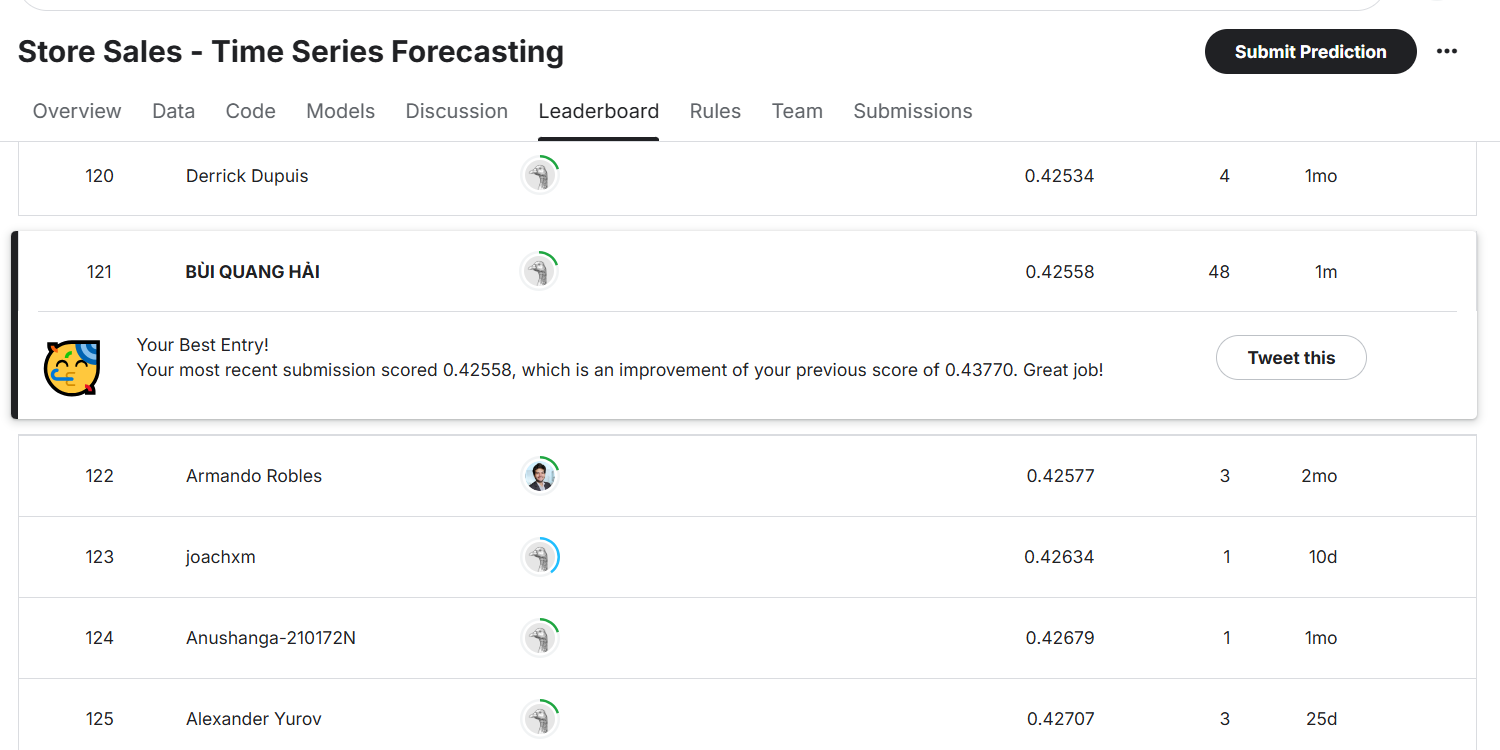

Score của mô hình đạt 121/778 (~15%)

In [200]:
submission = preds_models_per_family
submission.to_csv('multi_model_family.csv', index=False)